**Kmeans clustering** David Elorza 18/11/2023

**Importar los datos**
Vamos a usar la libreria de pandas para importar los datos del csv y convertirlos en un data frame con el que podamos trabajar.

In [80]:
import pandas as pd
import numpy as np
suicidal_data  = pd.read_csv("suicidal_data.csv",sep=",", encoding='cp1252')
suicide_detection = pd.read_csv("Suicide_Detection.csv", sep=",", encoding="utf-8")

In [81]:
suicidal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9206 entries, 0 to 9205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9206 non-null   int64 
 1   tweet   9206 non-null   object
dtypes: int64(1), object(1)
memory usage: 144.0+ KB


In [82]:
suicide_detection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [83]:
suicide_detection['class'] = suicide_detection['class'].replace({'non-suicide': 0, 'suicide': 1})


**DIFERENTES CONJUNTOS :** Se va a probar con introduccion de ruido progresiva, mezclando insercion, borrado y sustitución de caracteres aleatorios.

In [84]:
print("Las instancias están repartidas en las dos clases de la siguiente forma:")
print(suicidal_data['label'].value_counts(), end="\n")

Las instancias están repartidas en las dos clases de la siguiente forma:
label
0    5144
1    4062
Name: count, dtype: int64


In [85]:
# Check for duplicated instances
duplicated_instances = suicidal_data.duplicated().sum()
print("Instancias duplicadas:", duplicated_instances)

Instancias duplicadas: 327


In [86]:
print("Las instancias están repartidas en las dos clases de la siguiente forma:")
print(suicide_detection['class'].value_counts(), end="\n")

Las instancias están repartidas en las dos clases de la siguiente forma:
class
1    116037
0    116037
Name: count, dtype: int64


In [87]:
train = suicidal_data
print(type(suicidal_data))
print(type(train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>



****Preproceso :**** Para que los tweets tengan la información más relevante vamos a aplicar un preproceso de tal forma que se quiten signos de puntuación, mayúsuculas, stopwords y vamos a lematizar las palabras para que nos den toda la misma información.

In [88]:
import re
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt

print('Dataset size:',train.shape)
print('columns are:',train.columns)

Dataset size: (9206, 2)
columns are: Index(['label', 'tweet'], dtype='object')


In [89]:
train['tidy_tweet'] = np.vectorize(remove_pattern)(train['tweet'], "@[\w]*")
print(type(train['tidy_tweet']))

<class 'pandas.core.series.Series'>


In [90]:
import random
import string

# Función para insertar caracteres aleatorios en el texto
def insert_random_chars(text, percentage):
    n_chars = int(len(text) * percentage)
    for _ in range(n_chars):
        position = random.randint(0, len(text) - 1)
        random_char = random.choice(string.ascii_letters + string.digits)
        text = text[:position] + random_char + text[position:]
    return text

In [91]:
# Función para sustituir caracteres aleatorios en el texto
def substitute_random_chars(text, percentage):
    n_chars = int(len(text) * percentage)
    for _ in range(n_chars):
        position = random.randint(0, len(text) - 1)
        random_char = random.choice(string.ascii_letters + string.digits)
        text = text[:position] + random_char + text[position + 1:]
    return text

In [92]:
def remove_random_chars(text, percentage):
    n_chars = int(len(text) * percentage)
    for _ in range(n_chars):
        position = random.randint(0, len(text) - 1)
        text = text[:position] + text[position + 1:]
    return text

In [93]:
# Aplicar ruido a un porcentaje de muestras
noisy_train = train.copy()  # Copia del conjunto de datos original
percentage_of_noise = 0.09  # Porcentaje de ruido inicial

# Aplicar ruido a una parte del conjunto de datos
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: insert_random_chars(x, percentage_of_noise))
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: substitute_random_chars(x, percentage_of_noise))
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: remove_random_chars(x, percentage_of_noise))

In [94]:
train['tidy_tweet'] = train['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [95]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [96]:
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [lfe, smeaningless, jugst, wan, end, liO, soCa...
1    [mu3enbing, wanna, diYe, mlf, Idail4ly, jor, 1...
2    [wok, sae, i6reallyT, feel, ike, only, pufpyop...
3    [somthTng, onO, the, KoctobeQ, oerdoZedi, just...
4    [feel, like, lonl, cahes, ijuvst, wantG, a5e, ...
Name: tidy_tweet, dtype: object

In [97]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

train['tidy_tweet'] = tokenized_tweet

In [98]:
import nltk.corpus

stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['fuck', 'shit'])

In [99]:
def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

# combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: remove_stopwords(x)) # stemming
# combi.head()

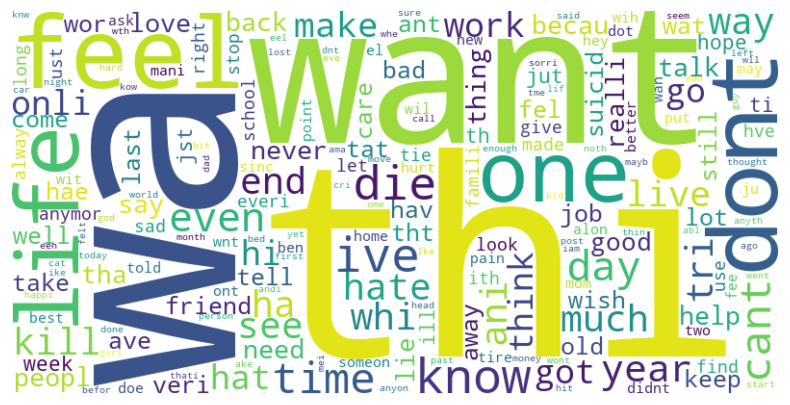

In [101]:
train['tidy_tweet'] = train['tidy_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword)]))

#visualize all the words our data using the wordcloud plot
all_words = ' '.join([text for text in train['tidy_tweet']])

from wordcloud import WordCloud
import matplotlib.pyplot as plt_lib
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the wordcloud
plt_lib.figure(figsize=(10, 5))
plt_lib.imshow(wordcloud, interpolation='bilinear')
plt_lib.axis('off')
plt_lib.show()

**Vectorizacion**

In [ ]:
#Word embbeding
import gensim
tokenized_tweet = train['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tidy_tweet']), epochs=20)

(3527519, 8259680)

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv.get_vector(word).reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary

            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(9206, 200)

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt   

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokenized_tweet)

# Display the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

TypeError: expected string or bytes-like object, got 'Series'

**Clustering**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, precision_score, recall_score, silhouette_score, confusion_matrix

kmeans = KMeans(n_clusters=2, random_state=42)

kmeans.fit(wordvec_df)
predicted_labels = kmeans.labels_

c:\Users\david\anaconda3\envs\mineriaDD\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Resultados**

In [ ]:
##########################################################
precision = precision_score(train['label'], predicted_labels)
print("Precision nuestro KMeans con w2v:", precision)

##########################################################
recall = recall_score(train['label'], predicted_labels)
print("Recall nuestro KMeans con w2v:", recall)

#########################################################
f1 = f1_score(train['label'], predicted_labels)
print("Puntuación F-Score para KMeans en todo el conjunto de datos:", f1)

##########################################################
silhouette_avg = silhouette_score(wordvec_df, predicted_labels)
print("Puntuación de la Silueta para KMeans en Word2Vec Features:", silhouette_avg)


Precision nuestro KMeans con w2v: 0.2048780487804878
Recall nuestro KMeans con w2v: 0.0103397341211226
Puntuación F-Score para KMeans en todo el conjunto de datos: 0.01968596203421608
Puntuación de la Silueta para KMeans en Word2Vec Features: 0.506464966527026


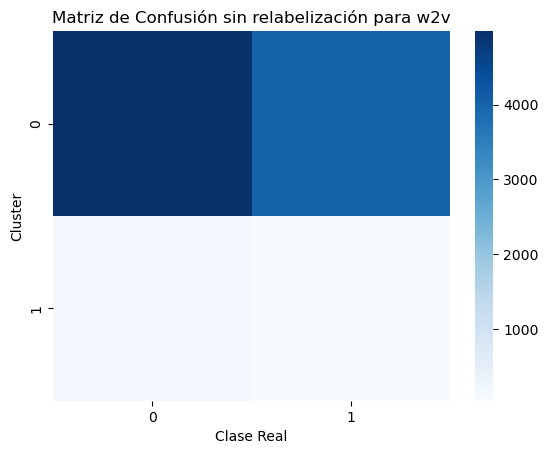

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
to_string = lambda x : str(x)
# Obtener matriz de confusión Class to clustering eval
cm = confusion_matrix(np.vectorize(to_string)(predicted_labels), np.vectorize(to_string)(train['label']))
# Mapa de calor a partir de la matriz de confusion sin números
ax = sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel('Clase Real')
plt.ylabel('Cluster')
plt.title('Matriz de Confusión sin relabelización para w2v')
plt.show()

In [ ]:
# Define una función para mapear clases reales a clusters
def class_to_cluster(predicted_labels, true_labels, cluster_labels):
    cluster_mapping = {}  # Diccionario para mapear clases a clusters
    for cluster_label in cluster_labels:
        cluster_instances = true_labels[predicted_labels == cluster_label]
        unique_classes, class_counts = np.unique(cluster_instances, return_counts=True)
        most_frequent_class = unique_classes[np.argmax(class_counts)]
        cluster_mapping[cluster_label] = most_frequent_class
    return cluster_mapping

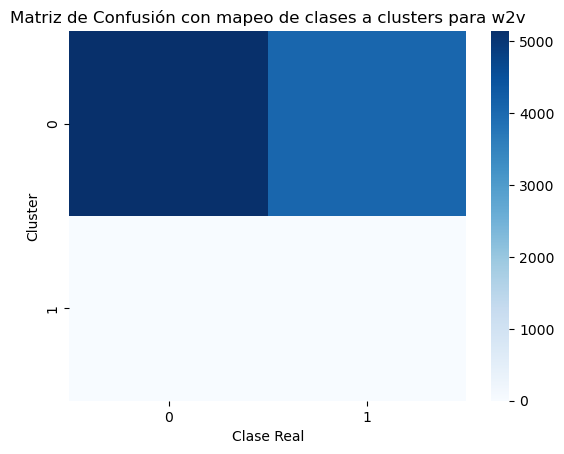

In [ ]:
# Supongamos que tienes predicted_labels_KM_w2v y train['label'] como tus etiquetas
# y los clusters generados por K-means en cluster_labels
cluster_mapping = class_to_cluster(predicted_labels, train['label'], np.unique(predicted_labels))

# Mapea las etiquetas reales a los clusters utilizando el diccionario cluster_mapping
mapped_labels = np.vectorize(cluster_mapping.get)(predicted_labels)

# Calcula la matriz de confusión
cm = confusion_matrix(np.vectorize(to_string)(mapped_labels), np.vectorize(to_string)(train['label']))

# Crea el mapa de calor a partir de la matriz de confusión
ax = sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel('Clase Real')
plt.ylabel('Cluster')
plt.title('Matriz de Confusión con mapeo de clases a clusters para w2v')
plt.show()

In [ ]:
# Calculate the confusion matrix with the reassigned labels
cm = confusion_matrix(train['label'], mapped_labels)
total_correct = np.trace(cm)  # Suma de valores en la diagonal principal
total_samples = np.sum(cm)    # Suma de todos los valores en la matriz de confusión

# Calcular el número total de clasificaciones incorrectas
total_incorrect = total_samples - total_correct

# Calcular la tasa de error
error_rate = total_incorrect / total_samples

print("Tasa de Error:", error_rate)

Tasa de Error: 0.4412339778405388


**Imprimir resultados**

In [ ]:
import csv
with open('introduccionRuido.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([f'Iteración nº: 1 -> Ruido de un 10%'])
    writer.writerow(['#############################  Datos ###############################'])
    writer.writerow(['1) Las instancias están repartidas en las dos clases de la siguiente forma:'])
    writer.writerow([train['label'].value_counts()])
    writer.writerow(['2) Instancias duplicadas:', duplicated_instances])
    writer.writerow(['################################## Resultados #######################'])
    writer.writerow(['1)  Precision nuestro KMeans con w2v:', precision])
    writer.writerow(['2)  Recall nuestro KMeans con w2v:', recall])
    writer.writerow(['3) Puntuación F-Score para KMeans en todo el conjunto de datos:', f1])
    writer.writerow(['4) Puntuación de la Silueta para KMeans en Word2Vec Features:', silhouette_avg])
    writer.writerow(['5) Tasa de Error:', error_rate])
    writer.writerow(['#################################################################'])
    writer.writerow(['#################################################################'])
    writer.writerow(['#################################################################'])
    writer.writerow("")


In [ ]:
precision = [0.6121596534653465,0.6091954022988506,0.44996580806929565,0.4493706769474997,0.44843908486419476,0.4496159060099413,0.4474721315167211, 0.2791666666666667, 0.25901639344262295, 0.22614840989399293]
recall = [0.9741506646971935,0.965534219596258, 0.9704579025110783,0.9756277695716395,0.9795667159034959,0.9798129000492368,0.9780896110290497, 0.016494337764647957, 0.019448547513540127, 0.013293943870014771]
fscore = [0.7518525555766672,0.7470476190476191,0.6151449049548146,0.6153248971353156,0.6152299961345188,0.6163853182592535,0.6140174638745074, 0.031148303114830307, 0.03618044424089764, 0.02528681807539218]
silhouette = [0.16612671491698686, 0.1502169333563163,0.1549010546337634,0.20125360900287845,0.27067646913101157,0.325261696389525,0.3363323336741518, 0.4235376299584025, 0.4278617388329748, 0.4628443944563953]
error = [0.2837280034759939,0.28850749511188356,0.4412339778405388,0.4412339778405388,0.4412339778405388,0.4412339778405388,0.44123397784053880,0.4412339778405388, 0.4412339778405388, 0.4412339778405388]


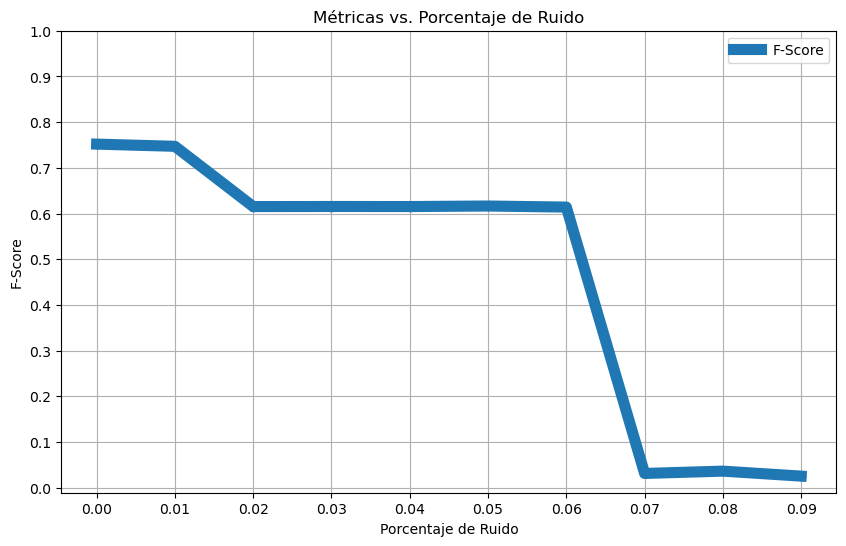

In [ ]:
# Porcentaje de ruido de 0.0 a 0.09 en incrementos de 0.01
porcentaje_ruido = [i * 0.01 for i in range(10)]

# Crear el gráfico
plt.figure(figsize=(10, 6))

plt.style.use('default')
plt.plot(porcentaje_ruido, fscore, label='F-Score', marker='o', linewidth=8)

# Configurar ejes y leyenda
plt.xlabel('Porcentaje de Ruido')
plt.ylabel('F-Score')
plt.title('Métricas vs. Porcentaje de Ruido')
plt.xticks(porcentaje_ruido)
plt.yticks([i * 0.1 for i in range(11)])
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()